# Import Required Libraries
Import the necessary libraries, including NumPy, Pandas, Matplotlib, and TensorFlow.

In [1]:
# Import Required Libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and Prepare Data
Load the data from the API and prepare it by converting date columns and handling missing values.

In [2]:
# Load and Prepare Data
url_base = 'http://localhost:3000/query2'

data_inicio = '01.01.2014'
data_final = '31.12.2023'

empresas = [
    {'Simbolo': 'Airbus', 'Ramo': 'Aviacao'},
    {'Simbolo': 'Air Canada', 'Ramo': 'Aviacao'},
    {'Simbolo': 'Air China', 'Ramo': 'Aviacao'},
    {'Simbolo': 'Apple', 'Ramo': 'Tecnologia'},
    {'Simbolo': 'Amazon', 'Ramo': 'Tecnologia'},
]

empresas_por_ramo = {}
for empresa in empresas:
    ramo = empresa['Ramo']
    simbolo = empresa['Simbolo']
    empresas_por_ramo.setdefault(ramo, []).append(simbolo)

print(empresas_por_ramo)

lista_dfs = []

for ramo, simbolos in empresas_por_ramo.items():
    params = {
        'ramo': ramo,
        'simbolos': ','.join(simbolos),  # Enviar símbolos separados por vírgula
        'data_inicio': data_inicio,
        'data_final': data_final
    }
    response = requests.get(url_base, params=params)
    if response.status_code == 200:
        data = response.json()
        df_ramo = pd.DataFrame(data)
        # Converter 'Data' e 'Fechamento'
        df_ramo['Data'] = pd.to_datetime(df_ramo['Data'], format='%d.%m.%Y')
        df_ramo['Fechamento'] = pd.to_numeric(df_ramo['Fechamento'], errors='coerce')
        lista_dfs.append(df_ramo)
    else:
        print(f"Erro ao buscar dados para o ramo {ramo}: {response.text}")

# Concatenar todos os DataFrames
df = pd.concat(lista_dfs, ignore_index=True)
df.dropna(subset=['Fechamento'], inplace=True)
df.head()

{'Aviacao': ['Airbus', 'Air Canada', 'Air China'], 'Tecnologia': ['Apple', 'Amazon']}


,Data,Fechamento,Fechamento_Padronizado,Simbolo,Ramo
0,2014-01-02,48.82,-0.1247010781261324,Airbus,Aviacao
1,2014-01-03,48.69,-0.1278039772927464,Airbus,Aviacao
2,2014-01-06,47.86,-0.1476147950488201,Airbus,Aviacao
3,2014-01-07,48.27,-0.1378287284464222,Airbus,Aviacao
4,2014-01-08,47.79,-0.1492855869077661,Airbus,Aviacao


# Filter Data from 2020 Onwards
Filter the dataset to include only data from January 1, 2020, onwards.

In [3]:
# Filter Data from 2020 Onwards
df = df[df['Data'] >= '2020-01-01']
df.head()

,Data,Fechamento,Fechamento_Padronizado,Simbolo,Ramo
1534,2020-01-02,128.36,1.77379584273905,Airbus,Aviacao
1535,2020-01-03,128.86,1.7857300703029495,Airbus,Aviacao
1536,2020-01-06,128.30,1.772363735431382,Airbus,Aviacao
1537,2020-01-07,126.90,1.7389478982524622,Airbus,Aviacao
1538,2020-01-08,129.18,1.7933679759438454,Airbus,Aviacao


# Plot Actual Data from 2020 Onwards
Plot the actual closing prices from 2020 onwards for visualization.

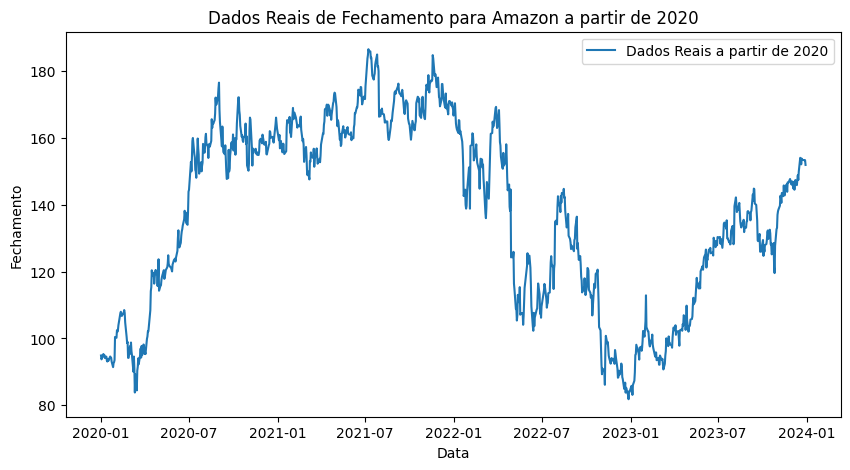

In [5]:
# Plot Actual Data from 2020 Onwards
empresa_especifica = 'Amazon'
df_empresa = df[df['Simbolo'] == empresa_especifica]

plt.figure(figsize=(10, 5))
plt.plot(df_empresa['Data'], df_empresa['Fechamento'], label='Dados Reais a partir de 2020')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title(f'Dados Reais de Fechamento para {empresa_especifica} a partir de 2020')
plt.legend()
plt.show()

# Prepare Data for LSTM Model
Prepare the data for the LSTM model by scaling and creating sequences.

In [6]:
# Prepare Data for LSTM Model
# Selecionar os dados da empresa específica
empresa_especifica = 'Amazon'
df_empresa = df[df['Simbolo'] == empresa_especifica]

# Preparar os dados
fechamento = df_empresa['Fechamento'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
fechamento_scaled = scaler.fit_transform(fechamento)

# Criar sequências de dados para o LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Usar 60 dias de dados para prever o próximo dia
X, y = create_sequences(fechamento_scaled, seq_length)

# Dividir os dados em treino e teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Create and Train LSTM Model
Create and train the LSTM model using the prepared data.

In [7]:
# Create and Train LSTM Model

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

c:\Users\lucca\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.1946 - val_loss: 0.0071
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0142 - val_loss: 0.0023
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0

# Make Predictions
Use the trained LSTM model to make predictions from 2020 onwards.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

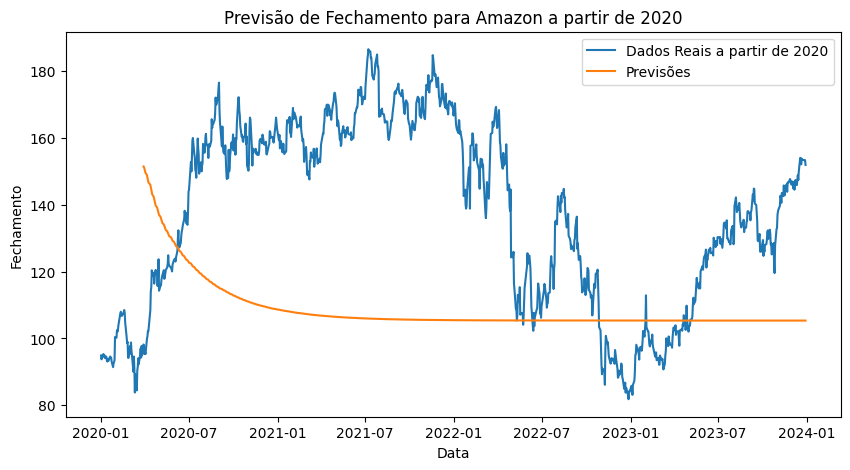

In [8]:
# Make Predictions
# Use the trained LSTM model to make predictions from 2020 onwards

# Fazer previsões a partir de 2020
predictions = []
current_batch = fechamento_scaled[-seq_length:].reshape((1, seq_length, 1))

for _ in range(len(df_empresa) - seq_length):
    pred = model.predict(current_batch)[0]
    predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

# Inverter a escala das previsões
predictions = scaler.inverse_transform(predictions)

# Plotar previsões
plt.figure(figsize=(10, 5))
plt.plot(df_empresa['Data'], df_empresa['Fechamento'], label='Dados Reais a partir de 2020')
future_dates = df_empresa['Data'].iloc[seq_length:]
plt.plot(future_dates, predictions, label='Previsões')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title(f'Previsão de Fechamento para {empresa_especifica} a partir de 2020')
plt.legend()
plt.show()

# Plot Predictions vs Actual Data
Plot the predictions against the actual data to compare the performance.

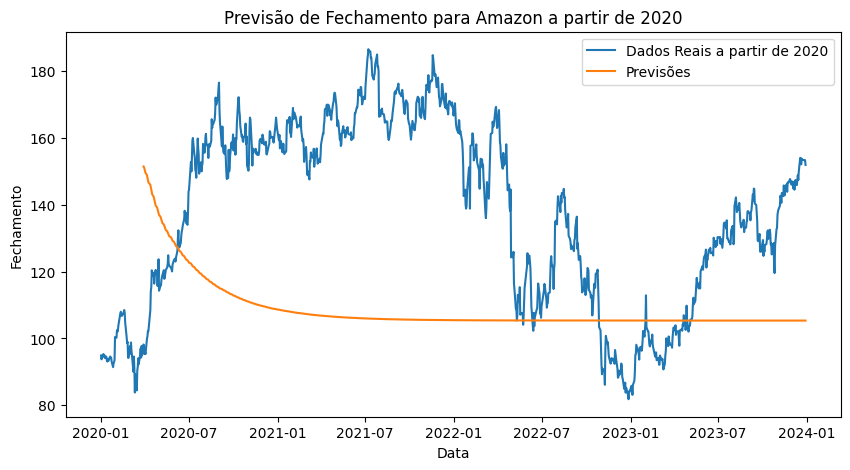

In [9]:
# Plot Predictions vs Actual Data
plt.figure(figsize=(10, 5))
plt.plot(df_empresa['Data'], df_empresa['Fechamento'], label='Dados Reais a partir de 2020')
future_dates = df_empresa['Data'].iloc[seq_length:]
plt.plot(future_dates, predictions, label='Previsões')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title(f'Previsão de Fechamento para {empresa_especifica} a partir de 2020')
plt.legend()
plt.show()